In [2]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import torch
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import difflib

import sys
sys.path.append('../AJA')
import AJA as aja

In [3]:
df_train_nodes, df_train_edges, df_test_nodes, df_test_edges = aja.get_data()

In [4]:
from sklearn.preprocessing import StandardScaler

def calculate_similarity(text, neighbors, df):
    max_similarity = 0.0
    if isinstance(neighbors, list):
        for neighbor in neighbors:
            if neighbor != []:
                if isinstance(neighbor, int):
                    neighbor_index = neighbor
                else:
                    neighbor_index = neighbor[0]
                neighbor_text = df.iloc[neighbor_index]['text']
                matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
                similarity = matcher.ratio()
                max_similarity = max(max_similarity, similarity)
    elif isinstance(neighbors, int):
        # Handle the case where 'neighbors' is an integer directly
        neighbor_index = neighbors
        neighbor_text = df.iloc[neighbor_index]['text']
        matcher = difflib.SequenceMatcher(None, text.split(), neighbor_text.split())
        max_similarity = matcher.ratio()
    return max_similarity

def f(df_nodes, df_edges):

    df = df_nodes

    scaler = StandardScaler()

    # sentence length normalized
    df['sentence_length'] = df['text'].apply(lambda s: len(s.split()))
    df['sentence_length'] = scaler.fit_transform(df['sentence_length'].values.reshape(-1, 1))

    df['nb_occurences'] = df['text'].apply(lambda x: sum(x.split().count(mot) for mot in ['uh', 'um', 'okay', '<', 'ah', 'oh']))
    df['nb_occurences'] = scaler.fit_transform(df['nb_occurences'].values.reshape(-1, 1))

    df['nb_words_more_5'] = df['text'].apply(lambda x: sum(len(mot) > 5 and mot.lower() != '<vocalsound>' for mot in x.split()))
    df['nb_words_more_5'] = scaler.fit_transform(df['nb_words_more_5'].values.reshape(-1, 1))


    # speaker hot-one encoding
    one_hot_encoded = pd.get_dummies(df['speaker_int'], prefix='speaker', dtype=int)
    df = df.drop('speaker_int', axis=1)
    df = df.drop('speaker_text', axis=1)
    df = pd.concat([df, one_hot_encoded], axis=1)
    return df

def g(df):
    new_df = pd.DataFrame({
        'transcription': df['transcription'],
        'start': df['end'],
        'end': df['start'],
        'type_int': 16 + df['type_int'],
        'type_text': df['type_text'] + "_reverse"
    })
    result_df = pd.concat([df, new_df], ignore_index=True)
    return result_df


In [5]:
df = f(df_train_nodes, df_train_edges)

In [6]:
df.describe()

,line,label,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_381,bert_382,bert_383,sentence_length,nb_occurences,nb_words_more_5,speaker_0,speaker_1,speaker_2,speaker_3
count,72623.000000,72623.000000,72623.000000,72623.000000,72623.000000,72623.000000,72623.000000,72623.000000,72623.000000,72623.000000,...,72623.000000,72623.000000,72623.000000,7.262300e+04,7.262300e+04,7.262300e+04,72623.000000,72623.000000,72623.000000,72623.000000
mean,450.495394,0.183027,-0.040099,-0.012195,-0.004467,-0.011361,0.019906,-0.007215,0.031095,-0.015504,...,0.003893,0.036122,0.005185,5.479035e-17,1.095807e-17,-2.348158e-17,0.332250,0.227655,0.230161,0.209933
std,335.844665,0.386692,0.054998,0.048177,0.040349,0.042922,0.055867,0.048295,0.056572,0.046471,...,0.051572,0.056326,0.042171,1.000007e+00,1.000007e+00,1.000007e+00,0.471023,0.419322,0.420939,0.407264
min,0.000000,0.000000,-0.207553,-0.207721,-0.177516,-0.171700,-0.177611,-0.183895,-0.185158,-0.191237,...,-0.240484,-0.205596,-0.230433,-1.008131e+00,-3.682526e-01,-7.952675e-01,0.000000,0.000000,0.000000,0.000000
25%,187.000000,0.000000,-0.070600,-0.047030,-0.031419,-0.039264,-0.019760,-0.041294,-0.009969,-0.048977,...,-0.027261,-0.001673,-0.025748,-7.085588e-01,-3.682526e-01,-7.952675e-01,0.000000,0.000000,0.000000,0.000000
50%,389.000000,0.000000,-0.039796,-0.008509,-0.006113,-0.006937,0.023805,-0.001537,0.027262,-0.014165,...,0.010742,0.044509,0.005664,-2.592005e-01,-3.682526e-01,-2.201474e-01,0.000000,0.000000,0.000000,0.000000
75%,644.000000,0.000000,-0.004414,0.018975,0.023079,0.018705,0.067422,0.028497,0.075861,0.012789,...,0.034162,0.080227,0.032021,3.399439e-01,-3.682526e-01,3.549727e-01,1.000000,0.000000,0.000000,0.000000
max,2159.000000,1.000000,0.200448,0.182305,0.167633,0.144697,0.193038,0.152165,0.252236,0.188261,...,0.214296,0.259051,0.182661,9.626682e+00,1.697070e+01,9.556894e+00,1.000000,1.000000,1.000000,1.000000


In [7]:
train_graphs, validation_graphs, test_graphs = aja.get_graphs(f, g, 0.3)

In [10]:
{**train_graphs, **validation_graphs}["ES2002a"].x

tensor([[-0.0578, -0.0858, -0.0357,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0549,  0.0476, -0.0326,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0547, -0.0738, -0.0172,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0490, -0.0256, -0.0372,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0189, -0.0551,  0.0594,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0644, -0.0946, -0.0021,  ...,  0.0000,  1.0000,  0.0000]])

In [11]:
# on check la forme des input
N_features = {**train_graphs, **validation_graphs}['ES2002a'].x.shape[1]
N_features

391

In [12]:
class MultiChannelsGCN(torch.nn.Module):
    
    def __init__(self, channels, input_dim, post_conv_dim, output_dim, identity=False):
        super(MultiChannelsGCN, self).__init__()
        self.identity = identity
        self.channels = channels
        self.input_dim = input_dim
        self.post_conv_dim = post_conv_dim
        self.output_dim = output_dim
        self.GCN = nn.ModuleList([GCNConv(input_dim, post_conv_dim) for _ in range(channels)])
        if identity:
            self.dense = nn.Linear(post_conv_dim * (channels + 1), output_dim)
            self.denseID = nn.Linear(input_dim, post_conv_dim)
        else:
            self.dense = nn.Linear(post_conv_dim * channels, output_dim)

    def forward(self, nodes, edges):
        X = []
        for k in range(self.channels):
            if len(edges[k]) == 0:
                x = torch.zeros(nodes.shape[0], self.post_conv_dim)
            else:
                x = F.relu(self.GCN[k](nodes, edges[k]))
            X.append(x)
        if self.identity:
            X.append(F.relu(self.denseID(nodes)))
        concat = torch.cat(X, dim=1)
        return F.relu(self.dense(concat))

In [17]:
# on définie son plus beau modèle

class NodeClassifier(torch.nn.Module):
    def __init__(self, channels, input_dim):
        super(NodeClassifier, self).__init__()
        self.GCN1 = MultiChannelsGCN(channels, input_dim, 50, 20, identity=True)
        self.dense1 = nn.Linear(20,1)

    def forward(self, data):
        nodes, edges = data.x, data.edge_index
        x = self.GCN1(nodes, edges)
        x = self.dense1(x)
        x = torch.sigmoid(x)
        return x

    def predict(self, graph):
        self.eval()
        with torch.no_grad():
            logits = self.forward(graph)
        return np.array((logits > 0.5).int()).flatten()

In [18]:
# Move the instantiation of the model outside the training loop
model = NodeClassifier(32, N_features)
model_name='test_base'

# Move the model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use DataLoader to create batches of data
train_loader = DataLoader(list(train_graphs.values()), batch_size=1, shuffle=True)
N_train = len(train_loader)
validation_loader = DataLoader(list(validation_graphs.values()), batch_size=1, shuffle=False)
N_validation = len(validation_loader)

# Define the loss function and optimizer
alpha = 0.2
gamma = 5
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor((1 - alpha) / alpha), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Nombre d'epochs
epochs = 5

from sklearn.metrics import f1_score
import time

# Train the model
best_f1_score = 0
for epoch in range(epochs):
    print('- Epoch', f'{epoch:03d}', '-')
    start_time = time.time()

    # training
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / N_train
    print('Loss:', f'{average_loss:.4f}')
    

    # Evaluate the model on the training set
    start_time = time.time()
    model.eval()
    f1_moyen_train = 0
    for data in train_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_train += f1
    f1_moyen_train /= N_train
    print('F1 train:', f1_moyen_train)

    # Evaluate the model on the validation set
    model.eval()
    f1_moyen_valid = 0
    for data in validation_loader:
        data = data.to(device)
        y_pred = model.predict(data)
        y_true = data.y.cpu().numpy()
        f1 = f1_score(y_true, y_pred)
        f1_moyen_valid += f1
    f1_moyen_valid /= N_validation
    print('F1 valid:', f1_moyen_valid)

    # callbacks ou autre
    if f1_moyen_valid > best_f1_score:
        print('It\'s better !' )
        torch.save(model.state_dict(), "training_states/" + model_name + "-best.pth")
    else:
        optimizer.param_groups[0]['lr'] /= 2
        print('Learning rate reduced to:', optimizer.param_groups[0]['lr'])

    end_time = time.time()
    epoch_time = end_time - start_time
    print('Epoch time:', epoch_time, 'seconds')
    print('')

model.load_state_dict(torch.load("training_states/" + model_name + "-best.pth"))

- Epoch 000 -
Loss: 0.9873
F1 train: 0.5644644012389153
F1 valid: 0.5784079725651217
It's better !
Epoch time: 2.6605963706970215 seconds

- Epoch 001 -
Loss: 0.9660
F1 train: 0.5690652642729505
F1 valid: 0.5781587370591897
It's better !
Epoch time: 2.622807264328003 seconds

- Epoch 002 -
Loss: 0.9616
F1 train: 0.5932404233985631
F1 valid: 0.5830123068871399
It's better !
Epoch time: 2.6210286617279053 seconds

- Epoch 003 -
Loss: 0.9557
F1 train: 0.600239571017448
F1 valid: 0.5818128490420506
It's better !
Epoch time: 2.607435703277588 seconds

- Epoch 004 -
Loss: 0.9498
F1 train: 0.6156343845914332
F1 valid: 0.580499814993498
It's better !
Epoch time: 2.5834262371063232 seconds



<All keys matched successfully>

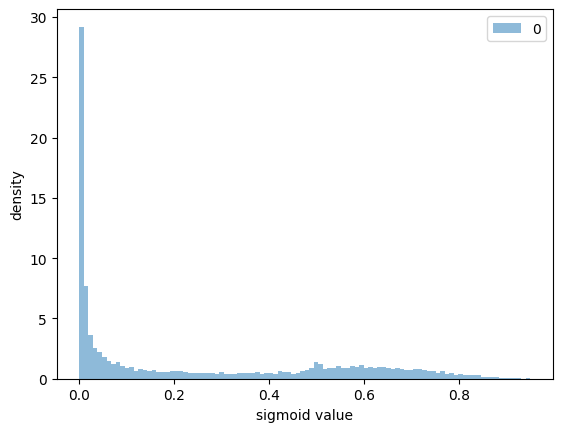

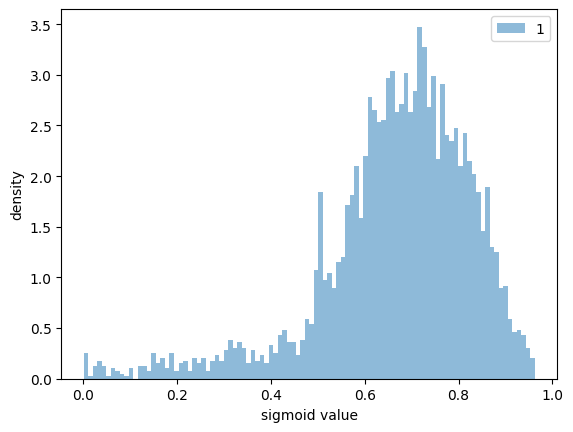

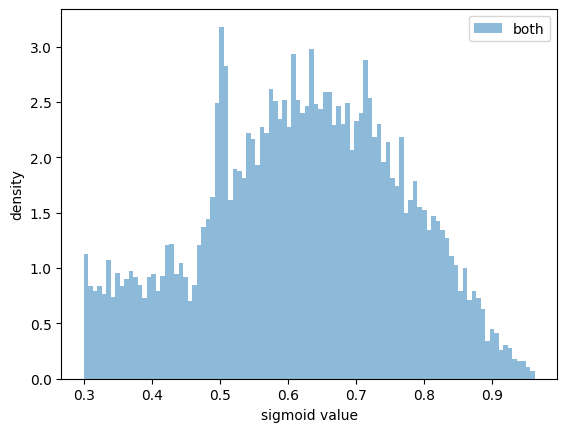

In [26]:
def show_logits_confusion_density():
    model.eval()
    logits = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            logits.append(torch.sigmoid(model(data)).squeeze().cpu().numpy())
            y_true.append(data.y.cpu().numpy())
    logits = np.concatenate(logits)
    y_true = np.concatenate(y_true)
    plt.hist(logits[y_true == 0], bins=100, alpha=0.5, label='0', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.hist(logits[y_true == 1], bins=100, alpha=0.5, label='1', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.hist(logits[logits > 0.3], bins=100, alpha=0.5, label='both', density=True)
    plt.xlabel('sigmoid value')
    plt.ylabel('density')
    plt.legend()
    plt.show()
show_logits_confusion_density()

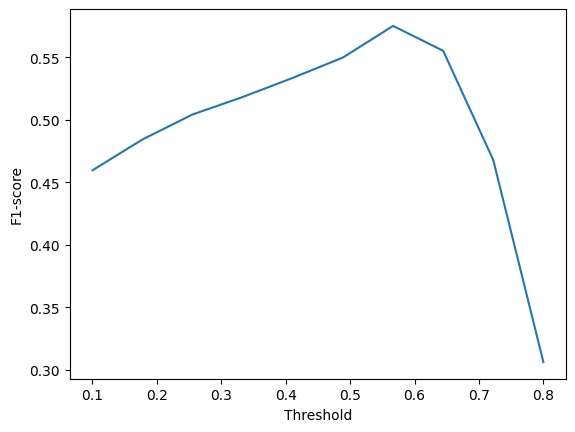

In [27]:
T = np.linspace(0.1,0.8,10)
f1s = []
for t in T:
    model.set_threshold(t)
    f1_valid = aja.f1_score_moyen(model, validation_graphs)
    f1s.append(f1_valid)

plt.plot(T, f1s)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.show()

In [22]:
# quand on est content on fait une submission !
model.set_threshold(0.75)
aja.make_test_csv_submission(model, test_graphs, 'avec_toutes_les_donnees')